In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn')
from collections import Counter

In [2]:
data_folder = 'data/'
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t')

/home/painguin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

### Chosen Fields

(at least some text that explains why we dropped the other fields)

In [3]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en', 'stores', 'countries_en',
                 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'carbon-footprint_100g', 'first_packaging_code_geo']

data = data[chosen_fields]

## Field Cleaning

The 'pnns_groups_1' field is particularly usefull in our study. 
Indeed, it sorts the different food entries by some clear category, as seen below.

A simple map allows for better organisation and also cleans the duplicate field entries:

In [4]:
my_map = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Fish Meat Eggs Dairy',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs Dairy',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}

data['Category'] = data['pnns_groups_1'].replace(my_map)

Now the categories are clear:

In [5]:
data['Category'].value_counts()

Unknown                 122881
Snacks                   37054
Fish Meat Eggs Dairy     31941
Composite                14670
Starchy                  14612
Fruits Vegetables        12632
Beverages                12411
Fat Sauces               11427
Name: Category, dtype: int64

From the 'main_category_en' field, we can recover more entries for the previous categories, as well as a new meaningfull category 'Plant-based foods and beverages', that we will rename 'Veggie' and add it as a new binary field in the data set.

In [6]:
data['main_category_en'].value_counts().head(20)

Plant-based foods and beverages    38524
Beverages                          26110
Sugary snacks                      25209
Dairies                            16145
Meats                               9801
Groceries                           9703
Meals                               8349
Spreads                             4629
Frozen foods                        3154
Fruit juices                        3108
Desserts                            3080
Salty snacks                        3008
Seafood                             2921
Canned foods                        2770
Fats                                1878
Baby foods                          1037
Sweeteners                           945
Sandwiches                           905
Farming products                     798
Fish and meat and eggs               741
Name: main_category_en, dtype: int64

First the usefull categories of `pnns_groups_1` and `main_category_en` are merged.
This merged categorical field is called `category`.

In [7]:
my_map_2 = {
    'Beverages' : 'Beverages',
    'Sugary snacks' : 'Snacks',
    'Dairies' : 'Fish Meat Eggs Dairy',
    'Meats' : 'Fish Meat Eggs Dairy',
    'Meals' : 'Composite',
    'Fruit juices' : 'Beverages',
    'Salty snacks' : 'Snacks',
    'Fats' : 'Fat Sauces',
    'Fish and meat and eggs' : 'Fish Meat Eggs Dairy'
}

In [8]:
not_in_category = data[data['Category'].isna()]
keys = my_map_2.keys()
not_in_category.query('main_category_en in @keys')['main_category_en'].value_counts()

Beverages                 5844
Meats                       68
Meals                       16
Fish and meat and eggs      12
Name: main_category_en, dtype: int64

We see that the number of usefull entries that are not already present in `pnns_group_1` are mainly from the `Beverages` category. Nonetheless, we build the new `Category` field as previously exposed, and add these categories, as well as the `pnns_group_1` fields.

In [9]:
# Adds the values in 'main_category_en' that are not in 'pnns_groups_1' after applying the map
new_vals = not_in_category.query('main_category_en in @keys')['main_category_en'].replace(my_map_2)
data.loc[new_vals.index, 'Category'] = new_vals

Here is the new 'Category' field.

In [10]:
data['Category'].value_counts()

Unknown                 122881
Snacks                   37054
Fish Meat Eggs Dairy     32021
Beverages                18255
Composite                14686
Starchy                  14612
Fruits Vegetables        12632
Fat Sauces               11427
Name: Category, dtype: int64

Now the `Plant based food and beverages category` is used to create a new field called `Veggie`.

In [11]:
data['Veggie'] = data['main_category_en'] == 'Plant-based foods and beverages'

The veggie fields from `Category` are also added:

In [12]:
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Fruits Vegetables')
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Starchy')

In [13]:
data['Veggie'].value_counts()

False    658551
True      39926
Name: Veggie, dtype: int64

Notice that the `False` value doesn't mean that an entry is not veggie.

# Nutri-Score

The Nutri-Score system was developped after Article 14 of the Modernisation Law for the health system, dated 26 January 2016, required the french authorities to recommend a front-of-pack system of labelling that would be simple and accessible for all. 
The new system includes a colour coded scheme, ranging from green to orange, associated with letters from A to E. Productes designated with an 'A' have the best nutritional quality, while products designated with an E have poorer nutritional quality.

## Points A

| Points | Energy (kJ) | Fat (g) | Sugar (g) | Sodium (mg) |
|:------:|:-----------:|:-------:|:---------:|:-----------:|
|    0   |    <=335    |   <=1   |   <=4.5   |     <=90    |
|    1   |     >335    |    >1   |    >4.5   |     >90     |
|    2   |     >670    |    >2   |     >9    |     >180    |
|    3   |    >1005    |    >3   |   >13.5   |     >270    |
|    4   |    >1340    |    >4   |    >18    |     >360    |
|    5   |    >1675    |    >5   |   >22.5   |     >450    |
|    6   |    >2010    |    >6   |    >27    |     >540    |
|    7   |    >2345    |    >7   |    >31    |     >630    |
|    8   |    >2680    |    >8   |    >36    |     >720    |
|    9   |    >3015    |    >9   |    >40    |     >810    |
|   10   |    >3350    |   >10   |    >45    |     >900    |

## Points C

| Points | Fruits Vegetables Nuts (%) | Fiber (g) | Proteins (g) |
|:------:|:--------------------------:|:---------:|:------------:|
|    0   |            <=40            |   <=0.9   |     <=1.6    |
|    1   |             >40            |    >0.9   |     >1.6     |
|    2   |             >60            |    >1.9   |     >3.2     |
|    3   |              -             |    >2.8   |     >4.8     |
|    4   |              -             |    >3.7   |     >6.4     |
|    5   |             >80            |    >4.7   |     >8.0     |

## Nutri-Score Computation
  * If `points A` < 11, then `score` = `points A` - `points C`
  * If `points A` >= 11:
      * If `points(Fruits/Vegetables/Nuts)` = 5, then `score` = `points(A)` - `points(C)`
      * If `points(Fruits/Vegetables/Nuts)` < 5, then `score` = `points(A)` - (`points(Fiber)` + `points(Fruits/Vegetables/Nuts)`)

## Letters Thresholds
### Solid Food
  * A: until -1
  * B: from 0 to 2
  * C: from 3 to 10
  * D: from 11 to 18
  * E: 19 and more
  
### Beverages 
  * A: mineral and spring water
  * B: until 1
  * C: from 2 to 5
  * D: from 6 to 9
  * E: 10 and more

## Warning
When fiber content is not present, its eventual positive contribution is not taken into account.

Percentages corresponding to Fruits/Vegetables/Nuts are mainly missing from the packaging. 
It will be derived from other products as follows:
  * 100% : Fruit Juices
  * 90% : Fruit Compote
  * 85% : Vegetables
  * 50% : Jams
  
Tubers are not considered as vegetables for the nutri-score.

In [14]:
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
beverages = data.query('Category == "Beverages"')

#### Compute points A

In [16]:
# energy
energy_bins = [data['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data['energy_100g'].max()]
data['energy_points'] = pd.cut(data['energy_100g'], energy_bins, labels=range(11)).astype(float)

# energy for beverages
bev_energy_bins = [beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, beverages['energy_100g'].max()]
bev_energy_points = pd.cut(beverages['energy_100g'], bev_energy_bins, labels=range(11), include_lowest=True)
data['energy_points'][bev_energy_points.index] = bev_energy_points

# fat
fat_bins = [data['fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data['fat_100g'].max()]
data['fat_points'] = pd.cut(data['fat_100g'], fat_bins, labels=range(11)).astype(float)

# sugar
sugar_bins = [data['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data['sugars_100g'].max()]
data['sugar_points'] = pd.cut(data['sugars_100g'], sugar_bins, labels=range(11)).astype(float)

# sugar for beverages
bev_sugar_bins = [beverages['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, beverages['sugars_100g'].max()]
bev_sugar_points = pd.cut(beverages['sugars_100g'], bev_sugar_bins, labels=range(11))
data['sugar_points'][bev_sugar_points.index] = bev_sugar_points

# sodium
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
data['sodium_points'] = pd.cut(data['sodium_100g'], sodium_bins, labels=range(11)).astype(float)

data['points_A'] = data['energy_points'] + data['fat_points'] + data['sugar_points'] + data['sodium_points']

/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Compute points C

In [17]:
# fruits-vegetables-nuts
fvn_bins = [data['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data['fruits-vegetables-nuts_100g'].max()]
data['fvn_points'] = pd.cut(data['fruits-vegetables-nuts_100g'], fvn_bins, labels=[0,1,2,5]).astype(float)

# fruits-vegetables-nuts for beverages
bev_fvn_bins = [beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, beverages['fruits-vegetables-nuts_100g'].max()]
bev_fvn_points = pd.cut(beverages['fruits-vegetables-nuts_100g'], bev_fvn_bins, labels=[0,2,4,10])
data['fvn_points'][bev_fvn_points.index] = bev_fvn_points

# fiber
fiber_bins = [data['fiber_100g'].min() - 1, 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]
data['fiber_points'] = pd.cut(data['fiber_100g'], fiber_bins, labels=range(6)).astype(float)
data['fiber_points'].fillna(0, inplace=True)

# proteins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
data['proteins_points'] = pd.cut(data['proteins_100g'], proteins_bins, labels=range(6)).astype(float)

data['points_C'] = data['fvn_points'] + data['fiber_points'] + data['proteins_points']

/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Compute nutri-score

We first compute the nutri-score based on the rules formula mentioned ahead.

In [18]:
def compute_score(row):
    A = row['points_A']
    C = row['points_C']
    fvn = row['fvn_points']
    fiber = row['fiber_points']
    if A < 11 or fvn == 5:
        return A - C
    else:
        return A - (fiber + fvn)

In [19]:
data['nutri-score'] = data.apply(compute_score, axis=1)

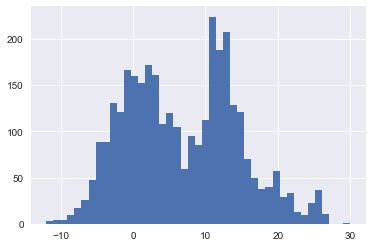

In [20]:
data['nutri-score'].hist(bins=int(data['nutri-score'].max() - data['nutri-score'].min() + 1))

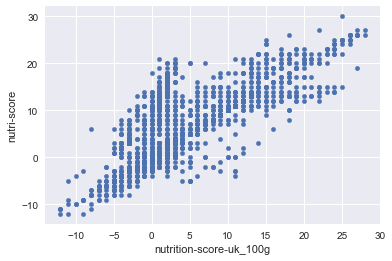

In [21]:
data.plot.scatter('nutrition-score-uk_100g', 'nutri-score')

Now we assign the letter corresponding to the nutri-score.

In [22]:
def nutri_score_letter(row):
    nutri_score = row['nutri-score']
    product_name = row['product_name']
    
    # check if nutri_score is nan
    if nutri_score != nutri_score:
        return np.nan
    
    if row['Category'] == 'Beverages':
        if product_name == product_name and 'mineral' in row['product_name']:
            return 'A'
        elif nutri_score <= 1:
            return 'B'
        elif nutri_score <= 5:
            return 'C'
        elif nutri_score <= 9:
            return 'D'
        else:
            return 'E'
    else:
        if nutri_score <= -1:
            return 'A'
        elif nutri_score <= 2:
            return 'B'
        elif nutri_score <= 10:
            return 'C'
        elif nutri_score <= 18:
            return 'D'
        else:
            return 'E'

In [23]:
data['nutri-score_letter'] = data.apply(nutri_score_letter, axis=1)

### Analyse the nutri-score across the categories

In [24]:
# Count the letter occurences for each category
letter_counts_per_cat = data.groupby(['Category', 'nutri-score_letter']).count()[['nutri-score']]
letter_counts_per_cat

nutri-score
Category             nutri-score_letter             
Beverages            B                            16
                     C                           131
                     D                            86
                     E                           485
Composite            A                           150
                     B                           113
                     C                           113
                     D                            33
Fat Sauces           A                             9
                     B                             7
                     C                            11
                     D                            21
                     E                            15
Fish Meat Eggs Dairy A                            39
                     B                            39
                     C                           138
                     D                            68
                     E                             2
Fruits Vegetables    A                           292
                     B                           104
                     C                            49
                     D                            17
                     E                             1
Snacks               A                             4
                     B                             8
                     C                           170
                     D                           253
                     E                           104
Starchy              A                            22
                     B                            13
                     C                            26
                     D                            22
                     E                             1
Unknown              A                           182
                     B                           153
                     C                           129
                     D                           197
                     E                            91

In [25]:
# For some categories, some letters are not represented. We add the missing rows with 0 as value.
for cat in letter_counts_per_cat.index.levels[0]:
    for letter in letter_counts_per_cat.index.levels[1]:
        if (cat, letter) not in letter_counts_per_cat.index:
            letter_counts_per_cat.loc[(cat, letter), :] = 0
            
letter_counts_per_cat.sort_index(inplace=True)

In [26]:
# normalize the counts
totals = letter_counts_per_cat.reset_index()[['Category', 'nutri-score']].groupby('Category').sum()
score_distr_per_cat = letter_counts_per_cat / totals

In [27]:
# colors similar to the original nutri-score ones
nutri_score_colors = ['green', 'limegreen', 'gold', 'darkorange', 'orangered']

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


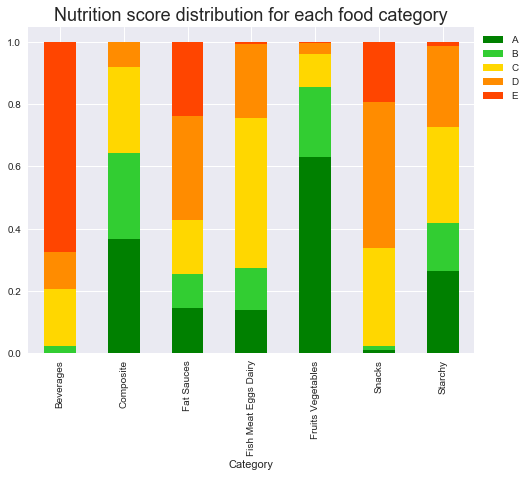

In [28]:
score_distr_per_cat.drop('Unknown').reset_index().pivot(index='Category', columns='nutri-score_letter', values='nutri-score').plot.bar(stacked=True, figsize=(8,6), colors=nutri_score_colors)
plt.legend(bbox_to_anchor=(1, 1.0))
plt.title('Nutrition score distribution for each food category', fontsize=18);

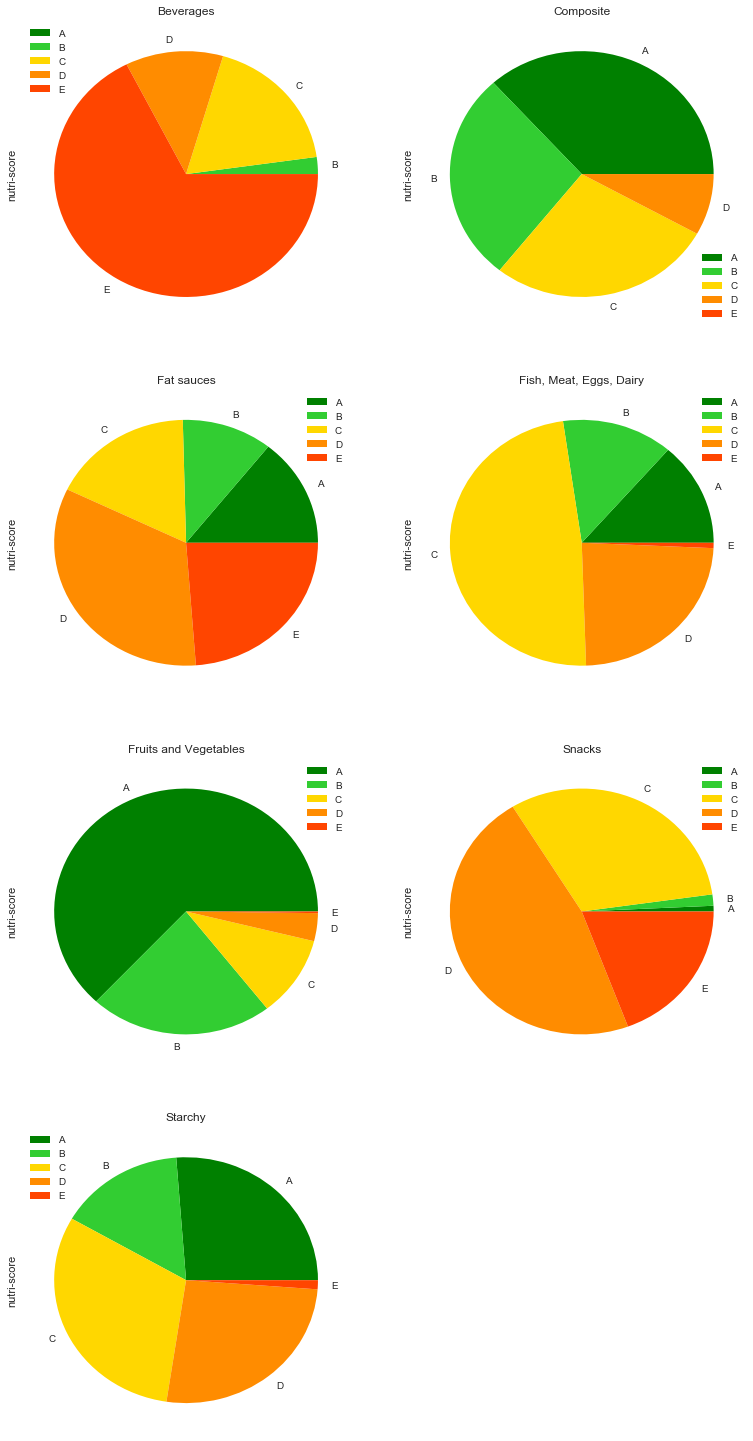

In [29]:
plt.figure(figsize=(13, 26))
letter_counts_per_cat.loc['Beverages'].plot.pie('nutri-score', ax=plt.subplot(421), title='Beverages', colors=nutri_score_colors)
letter_counts_per_cat.loc['Composite'].plot.pie('nutri-score', ax=plt.subplot(422), title='Composite', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fat Sauces'].plot.pie('nutri-score', ax=plt.subplot(423), title='Fat sauces', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fish Meat Eggs Dairy'].plot.pie('nutri-score', ax=plt.subplot(424), title='Fish, Meat, Eggs, Dairy', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fruits Vegetables'].plot.pie('nutri-score', ax=plt.subplot(425), title='Fruits and Vegetables', colors=nutri_score_colors)
letter_counts_per_cat.loc['Snacks'].plot.pie('nutri-score', ax=plt.subplot(426), title='Snacks', colors=nutri_score_colors)
letter_counts_per_cat.loc['Starchy'].plot.pie('nutri-score', ax=plt.subplot(427), title='Starchy', colors=nutri_score_colors)

In [30]:
score_mean_by_category = data[['Category', 'nutri-score']].groupby('Category').mean()
score_mean_by_category

,nutri-score
Category,
Beverages,11.002786
Composite,1.511002
Fat Sauces,10.000000
Fish Meat Eggs Dairy,5.430070
Fruits Vegetables,-1.166307
Snacks,12.706865
Starchy,4.869048
Unknown,6.894947


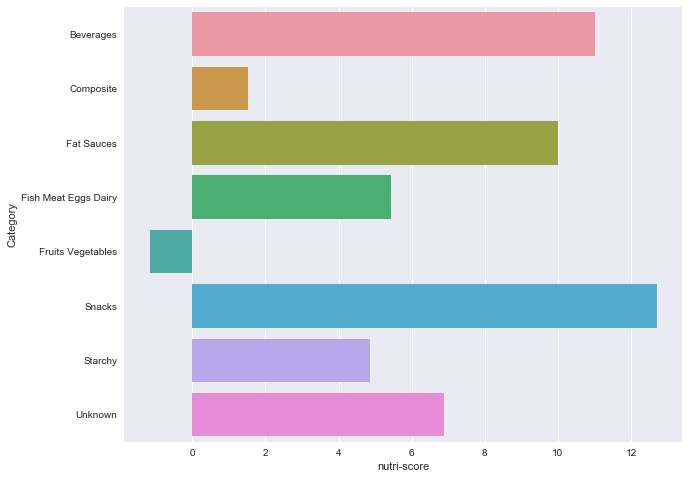

In [31]:
plt.figure(figsize=(10,8))
sns.barplot(score_mean_by_category['nutri-score'], score_mean_by_category.index,orient='h')

In [32]:
carbon_mean_by_category = data[['Category', 'carbon-footprint_100g']].groupby('Category').mean()

In [33]:
pd.concat((carbon_mean_by_category, score_mean_by_category), axis=1).corr()

,carbon-footprint_100g,nutri-score
carbon-footprint_100g,1.000000,0.083368
nutri-score,0.083368,1.000000


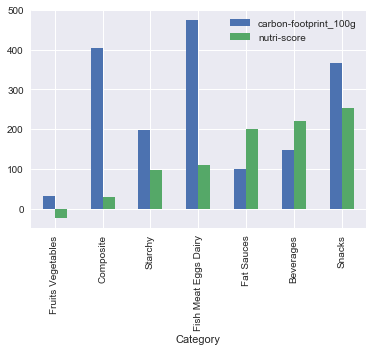

In [34]:
pd.concat((carbon_mean_by_category, 20*score_mean_by_category), axis=1).drop('Unknown').sort_values('nutri-score').plot.bar()

In [35]:
countries_en_scores = {}

In [36]:
def random_stuff(row):
    letter = row['nutri-score_letter']
    if letter == letter:
        for exportator in row['countries_en'].split(','):
            if exportator in countries_en_scores:
                countries_en_scores[exportator] += [row['nutri-score_letter']]
            else:
                countries_en_scores[exportator] = [row['nutri-score_letter']]

In [37]:
data[data['countries_en'].notna()].apply(random_stuff, axis=1);

In [38]:
threshold = 1

In [39]:
{country: Counter(countries_en_scores[country]) for country in countries_en_scores if len(countries_en_scores[country]) > threshold}

{'France': Counter({'E': 680, 'B': 438, 'A': 679, 'C': 731, 'D': 681}),
 'United Kingdom': Counter({'A': 11, 'C': 29, 'B': 14, 'D': 7, 'E': 2}),
 'United States': Counter({'E': 6, 'C': 2, 'A': 3, 'D': 3}),
 'Canada': Counter({'B': 1, 'D': 1}),
 'Belgium': Counter({'D': 19, 'C': 21, 'E': 12, 'B': 15, 'A': 19}),
 'French Polynesia': Counter({'B': 1, 'C': 2, 'A': 3, 'E': 1}),
 'Switzerland': Counter({'E': 21, 'C': 24, 'D': 22, 'A': 11, 'B': 7}),
 'Germany': Counter({'E': 7, 'C': 10, 'D': 11, 'A': 6, 'B': 4}),
 'Italy': Counter({'E': 9, 'C': 1, 'D': 2, 'A': 3, 'B': 1}),
 'Netherlands': Counter({'C': 7, 'E': 2, 'D': 3, 'A': 1}),
 'Spain': Counter({'C': 6, 'A': 6, 'D': 5, 'B': 3, 'E': 2}),
 'Sweden': Counter({'A': 3, 'B': 1}),
 'Portugal': Counter({'C': 3, 'D': 2, 'E': 1}),
 'Réunion': Counter({'E': 8, 'C': 3, 'D': 2, 'B': 3}),
 'Guadeloupe': Counter({'C': 1, 'E': 4}),
 'En': Counter({'B': 1, 'A': 2, 'D': 2, 'E': 1}),
 'Martinique': Counter({'E': 3}),
 'Algeria': Counter({'C': 1, 'E': 1}),
 